# Statistical foundation of machine learning

In [2]:
import numpy as np
from prep import TimeWindowTransformer, LabelWindowExtractor

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# adjust import if needed

## Loading raw data

In [3]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'guided' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

## (Optional) Signal filtering

if you plan to filter your sEMG signals, it is recommended to perform
this preprocessing step directly on the continuous raw data prior to window extraction or feature
computation. Note that this step is completely optional but may improve your results.

## (0.5 point) Dataset preparation and augmentation through overlapping windows

You should first segment your sEMG signals into smaller windows of fixed size k = 500. These windows should be created with a chosen degree of overlap, which you can adjust based on the computational and memory resources available to you. Keep in mind that a larger overlap results in a greater number of samples and thus a larger dataset to train your models but to the cost of increasing computational demands.

### 
To prepare our dataset for regression tasks, we segment the continuous surface electromyography (sEMG) signals into smaller overlapping windows of fixed size. This preprocessing step is crucial as it enables the learning models to capture localized temporal patterns in muscle activity and link them to corresponding hand pose estimations.

We chose a **window size `k = 500` samples**, which corresponds to roughly **0.49 seconds** of sEMG data, given the sampling rate of **1024 Hz**. This window size strikes a balance between capturing enough signal dynamics and ensuring real-time usability for prosthesis control.

We implemented a **50% overlap**, meaning each window starts 250 samples after the previous one. This overlap increases the number of training samples without excessively inflating computational costs. Larger overlaps (e.g., 75%) generate even more samples but demand significantly more memory and processing time, which may not scale efficiently depending on available resources.

This approach is implemented using two custom transformer classes:
- `TimeWindowTransformer`: Applies sliding windows to the raw sEMG signals.
- `LabelWindowExtractor`: Aligns the corresponding joint angle labels by sampling at the end of each time window.

This transformation ensures consistent alignment between each input window and its output label, facilitating supervised learning.

In [4]:
# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_windows = tw_transformer.transform(X)     # shape: (5, n_windows, 8, 500)
Y_labels = label_extractor.transform(Y)     # shape: (5, n_windows, 51)

# Inspect shapes
print("X_windows shape:", X_windows.shape)
print("Y_labels shape:", Y_labels.shape)


X_windows shape: (5, 919, 8, 500)
Y_labels shape: (5, 919, 51)


## (1 point) Cross-validation strategy

Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation. Provide a detailed justification showing that your validation sets remain completely independent from the training set. Include reasoning or evidence demonstrating explicitly that your chosen partitioning strategy prevents data leakage or bias, ensuring the reliability and generalizability of your model performance estimates.

###
To rigorously evaluate the performance and generalization capabilities of our regression models, we implemented a **cross-validation strategy** that ensures independence between training and validation data and avoids data leakage.

The available data consists of 5 recording sessions. We use the first **4 sessions** (`X_train_val_folds`, `Y_train_val_folds`) for training and validation, and **reserve the 5th session** (`X_test`, `Y_test`) as a completely unseen test set. This separation allows us to simulate real-world scenarios where the model encounters entirely new data from the same participant.

In [5]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

Within the 4 training sessions, we assess the estimator performance using a by training it on 75% of the training set and evaluating it on the remaining 25%, representing a “holdout" portion of the data that the model has never seen. To prevent potential bias due to specificities in portions of the training set, we use a stratified **4-fold cross-validation** and report the root mean squared error (**RMSE**) and normalized mean squared error (**NMSE**) across all. This strategy ensures:

- **Complete independence** between training and validation data in each fold
- Robust estimation of the model's performance across different recording sessions
- Reduced risk of overfitting to session-specific artifacts

This strategy provides insights into how well the model generalizes to other sessions from the same participant. However, it does not provide any information on the estimator’s ability to generalize to data from different participants.

We implemented this strategy creating a 'cross_validate_pipeline' utility function to handle the fold-based evaluation of any sklearn-compatible pipeline:

- Trains on 3 sessions and validates on the 4th (rotating fold)
- Reports both training and validation scores for each fold
- Computes mean performance across all folds for better interpretability

## (3 points) Baseline approach

Create a custom class inheriting from scikit-learn’s `BaseEstimator`
and `TransformerMixin` that implements the extraction of common time-domain features described
in section 3.1. Note that the features described in Section 3.1 represent the minimal required set. We
encourage you to include additional features or preprocessing steps if you would like to further improve your model performances. Select at least two different regression models, compare their cross-validated performance, and evaluate their feature importances. For both models, perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE).
Clearly document this process in your notebook, discussing the outcomes in detail. Finally, create a
scikit-learn `Pipeline` that integrates your custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.
Using visualizations and tables to illustrate your findings, and employing formulas or pseudo-code
to explain the feature selection procedure, is strongly encouraged. Note that one-third of the score
will depend on the quality and clarity of your documentation.

**Disclaimer:** EVERY model/pipeline we create MUST take in input a numpy array of shape (N, 8, 500) and return a numpy array of shape (N, 51). The usage is:

model.fit(X, y)  --> Here X is of shape (N, 8, 500), y is of shape (N, 51) ; we are not supposed to use the return of this method, the method changes the model in place.

model.predict(X) --> Here X is of shape (N, 8, 500), and the return is of shape (N, 51)

The transformers have a fit_transform() method, which is the only one used. They take (N, 8, 500) and return something else of shape (N,...) depending on which transformer is used.

#### Baseline models - guided

In [6]:
from prep import TimeDomainTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from validation import RMSE, NMSE, cross_validate_pipeline

In [7]:
baseline1 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.001,
            kernel='laplacian'))
    ]
)

baseline2 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor())
    ]
)

baseline3 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ]
)

In [9]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline1,
    'Time domain features + KNN': baseline2,
    'Time domain features + Random Forests': baseline3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)



Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.0181, val=5.1703
NMSE: train=0.0000, val=0.1351

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144

Model: Time domain features + Random Forests

Average Scores across folds:
RMSE: train=1.1835, val=5.1831
NMSE: train=0.0070, val=0.1388


#### Hyperparameter tuning

In [14]:
from sklearn.model_selection import ParameterGrid

param_grids = {
    'Time domain features + Kernel Ridge': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'regressor__gamma': [0.001, 0.01, 0.1],
        'regressor__kernel': ['rbf', 'laplacian', 'poly']
    },
    'Time domain features + KNN': {
        'regressor__n_neighbors': [3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50]
    },
    'Time domain features + Random Forests': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 5, 10],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    }
}

all_results = {}

for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}")
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results


Tuning Model: Time domain features + Kernel Ridge

Tuning Model: Time domain features + KNN

Tuning Model: Time domain features + Random Forests


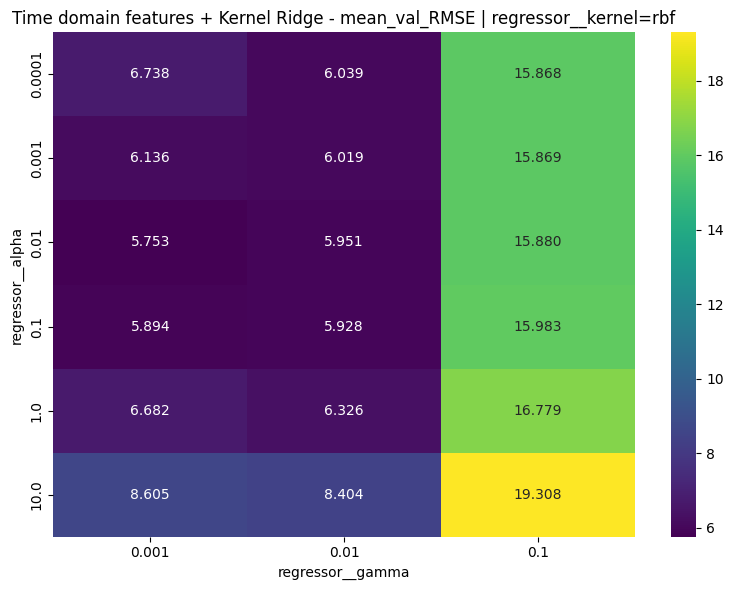

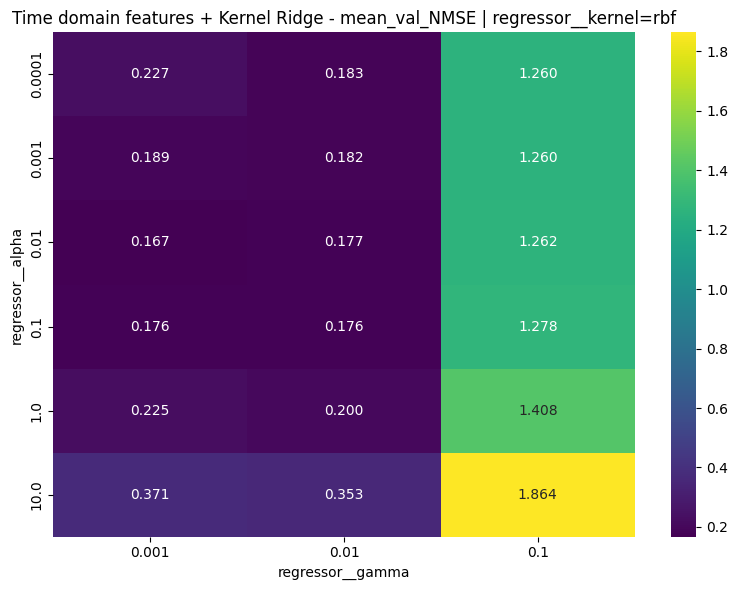

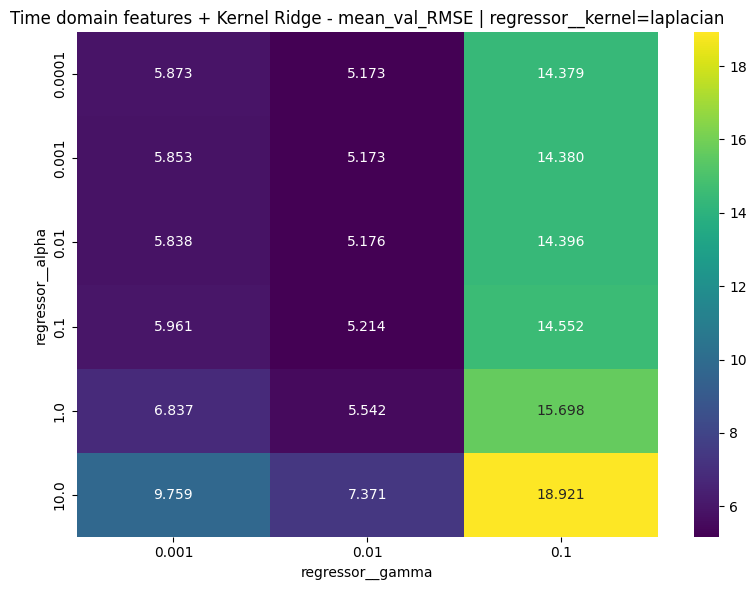

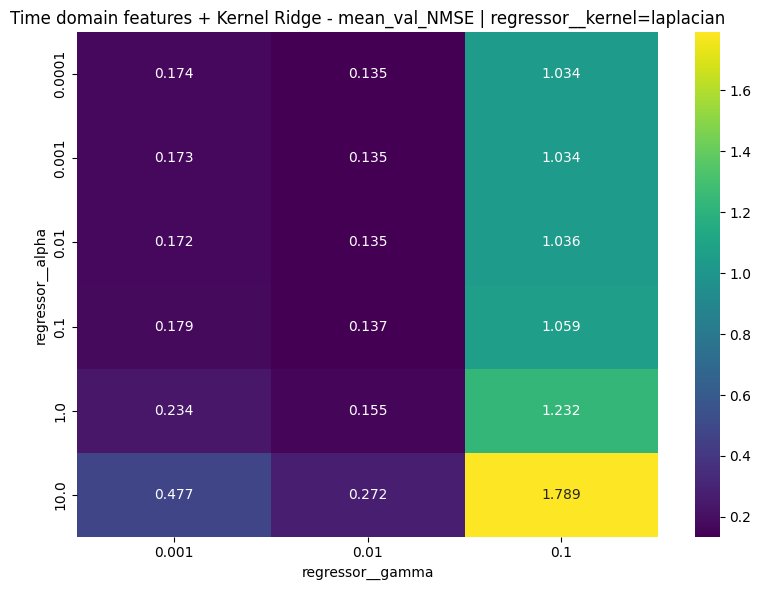

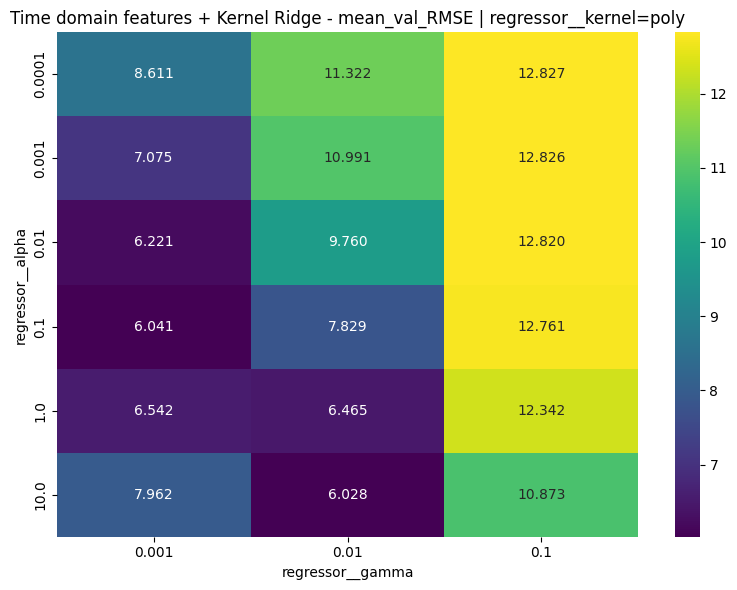

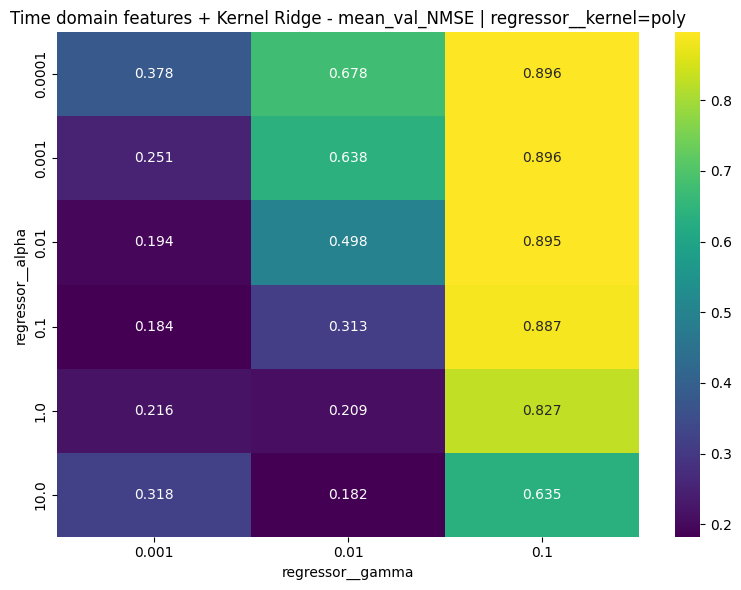

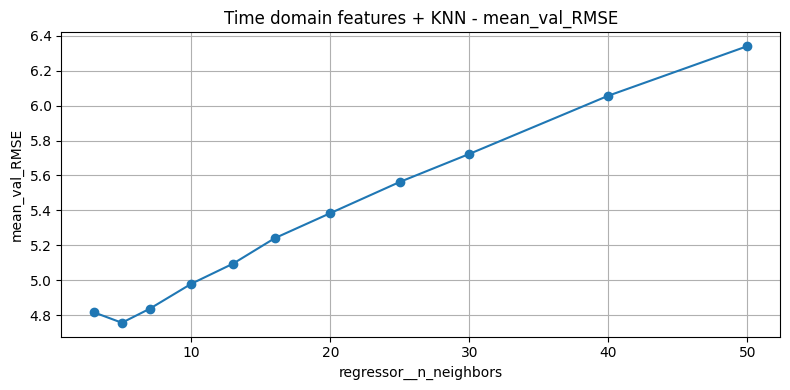

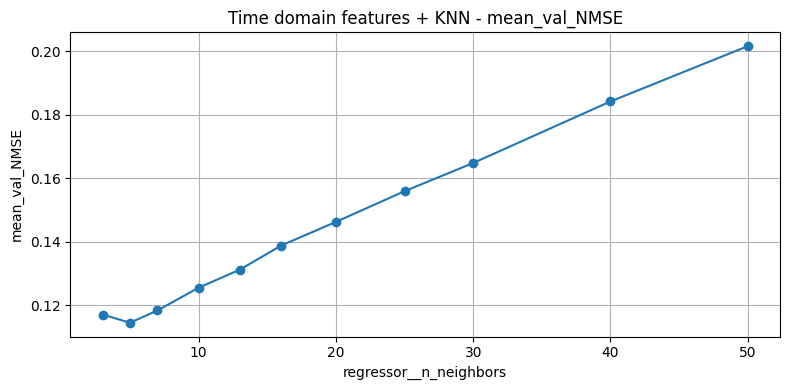

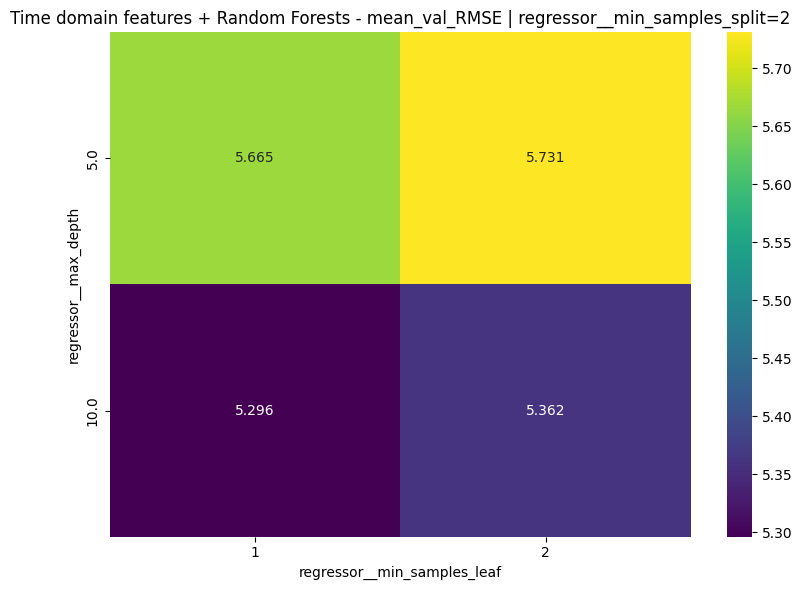

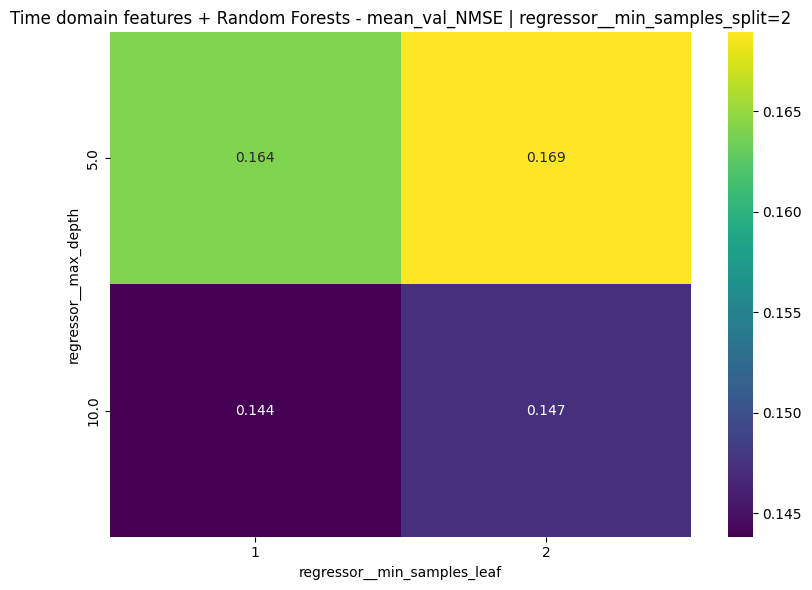

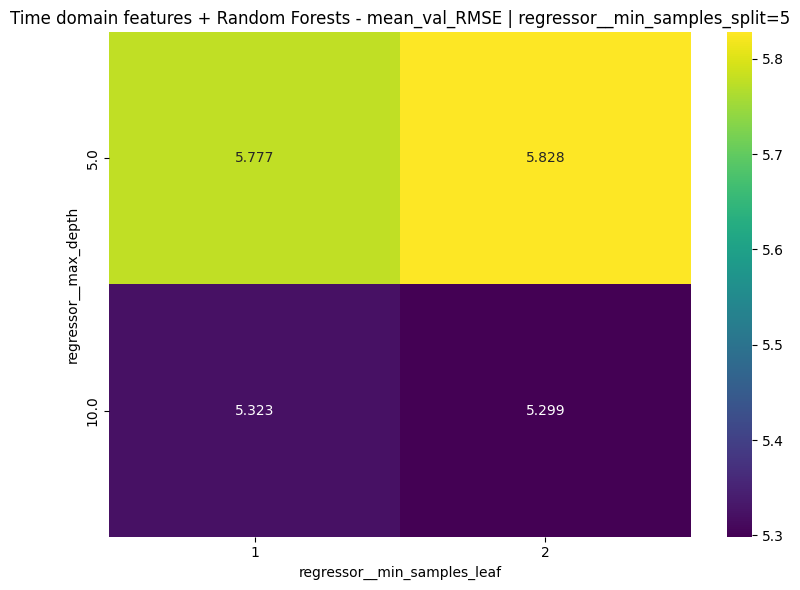

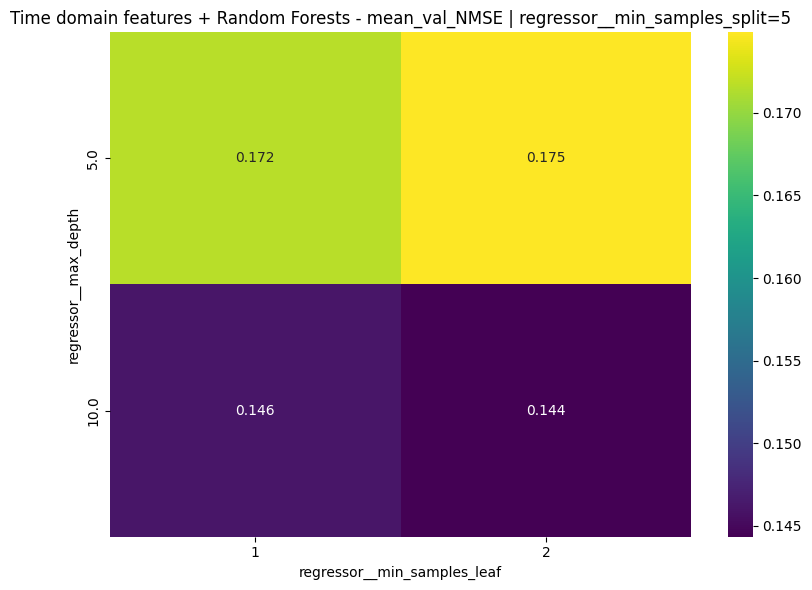

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_grid_results(model_name, results):
    """
    Plots RMSE and NMSE heatmaps or line plots for a given model's grid search results.

    Args:
        model_name (str): name of the model
        results (list of dict): results from parameter tuning
    """
    df = pd.DataFrame(results)
    param_cols = [col for col in df['params'][0].keys()]
    for col in param_cols:
        df[f'param_{col}'] = df['params'].apply(lambda d: d[col])

    if len(param_cols) == 1:
        p = f'param_{param_cols[0]}'
        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            plt.figure(figsize=(8, 4))
            plt.plot(df[p], df[metric], marker='o')
            plt.xlabel(param_cols[0])
            plt.ylabel(metric)
            plt.title(f'{model_name} - {metric}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    elif len(param_cols) == 2:
        p1, p2 = f'param_{param_cols[0]}', f'param_{param_cols[1]}'
        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            df.pivot_table(index=p1, columns=p2, values=metric, aggfunc='mean')
            plt.figure(figsize=(8, 6))
            sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
            plt.title(f'{model_name} - {metric}')
            plt.xlabel(param_cols[1])
            plt.ylabel(param_cols[0])
            plt.tight_layout()
            plt.show()

    else:
        # For >2 hyperparameters, plot line plots for each value of the third+ param
        fixed_param = param_cols[2]
        values = df[f'param_{fixed_param}'].unique()
        for val in values:
            df_subset = df[df[f'param_{fixed_param}'] == val]
            p1, p2 = f'param_{param_cols[0]}', f'param_{param_cols[1]}'
            for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
                pivot = df_subset.pivot_table(index=p1, columns=p2, values=metric, aggfunc='mean')
                plt.figure(figsize=(8, 6))
                sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
                plt.title(f'{model_name} - {metric} | {fixed_param}={val}')
                plt.xlabel(param_cols[1])
                plt.ylabel(param_cols[0])
                plt.tight_layout()
                plt.show()


for model_name, results in all_results.items():
    plot_grid_results(model_name, results)

#### Features selection

In [ ]:
# Feature selection
from sklearn.model_selection import KFold

# Flatten and extract time domain features
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)
y_flat = Y_train_val_folds.reshape(-1, 51)[:, 0]  # predict first joint for now

# Apply time-domain transformer manually for feature selection
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(X_flat.shape[0], -1)
X_df = pd.DataFrame(X_feat)
y_series = pd.Series(y_flat)
n = X_df.shape[1]
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Mutual information approximation via correlation
def mutual_info_corr(X, Y):
    c = np.corrcoef(X, Y)[0, 1]
    if abs(c) == 1:
        c = 0.999999
    return -0.5 * np.log(1 - c**2)

def compute_mi_vector(X_tr, Y_tr):
    mis = []
    for col in X_tr.columns:
        mi = mutual_info_corr(X_tr[col].values, Y_tr)
        mis.append(mi)
    return np.array(mis)

# Correlation Ranking - ignores redundancy between features 
correlations = np.abs(X_df.corrwith(y_series))
ranking_corr_idx = correlations.sort_values(ascending=False).index.tolist()
CV_err_corr = np.zeros((n, 4))

for fold_id, (train_index, test_index) in enumerate(kf.split(X_df)):
    X_tr, X_ts = X_df.iloc[train_index], X_df.iloc[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    for nb_features in range(1, n + 1):
        selected_features = ranking_corr_idx[:nb_features]
        model = KernelRidge()
        model.fit(X_tr[selected_features], Y_tr)
        Y_hat_ts = model.predict(X_ts[selected_features])
        CV_err_corr[nb_features - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nCorrelation Ranking")
for i in range(n):
    print(f"#Features: {i+1}; CV error = {CV_err_corr[i,:].mean():.4f}; std dev = {CV_err_corr[i,:].std():.4f}")

In [ ]:
# mRMR Ranking - requires mutual information computation
CV_err_mrmr = np.zeros((n, 4))
for fold_id, (train_index, test_index) in enumerate(kf.split(X_df)):
    X_tr, X_ts = X_df.iloc[train_index], X_df.iloc[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))

    for j in range(n):
        redundancy_score = np.zeros(len(candidates))
        if len(selected) > 0:
            for cidx in candidates:
                col_c = X_tr.iloc[:, cidx]
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx]
                    cc = np.corrcoef(col_s, col_c)[0, 1]
                    if abs(cc) == 1:
                        cc = 0.999999
                    mis_c.append(-0.5 * np.log(1 - cc**2))
                redundancy_score[candidates.index(cidx)] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)

    for nb_features in range(1, n + 1):
        features_to_use = [X_df.columns[i] for i in selected[:nb_features]]
        model = KernelRidge()
        model.fit(X_tr[features_to_use], Y_tr)
        Y_hat_ts = model.predict(X_ts[features_to_use])
        CV_err_mrmr[nb_features - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nmRMR Ranking")
for i in range(n):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")

In [ ]:
# PCA - produces unstructured components (not original features)
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_df)
CV_err_pca = np.zeros((n, 4))
for fold_id, (train_index, test_index) in enumerate(kf.split(X_pca)):
    X_tr, X_ts = X_pca[train_index], X_pca[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    for nb_components in range(1, n + 1):
        model = KernelRidge()
        model.fit(X_tr[:, :nb_components], Y_tr)
        Y_hat_ts = model.predict(X_ts[:, :nb_components])
        CV_err_pca[nb_components - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nPCA Components")
for i in range(n):
    print(f"#Components: {i+1}; CV error = {CV_err_pca[i,:].mean():.4f}; std dev = {CV_err_pca[i,:].std():.4f}")

### Riemannian geometry pipelines

In [20]:
import pyriemann
import pyriemann.regression
from sklearn.multioutput import MultiOutputRegressor

In [21]:
# Riemannian geometry of covariance matrices
riem1 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KernelRidge(
            kernel='laplacian'))
    ]
)

riem2 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KNeighborsRegressor())
    ]
)

riem3 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', RandomForestRegressor())
    ]
)

In [24]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Riemann + Kernel Ridge': riem1,
    'Riemann + KNN': riem2,
    'Riemann + Random Forest': riem3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Riemann + Kernel Ridge

Average Scores across folds:
RMSE: train=4.1274, val=5.6207
NMSE: train=0.0848, val=0.1591

Model: Riemann + KNN

Average Scores across folds:
RMSE: train=2.1140, val=5.1833
NMSE: train=0.0223, val=0.1358

Model: Riemann + Random Forest

Average Scores across folds:
RMSE: train=1.3251, val=4.9036
NMSE: train=0.0087, val=0.1230


#### Hyperparameter tuning

In [25]:
param_grids = {
    'Riemann + Kernel Ridge': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'regressor__gamma': [0.001, 0.01, 0.1],
        'regressor__kernel': ['laplacian', 'rbf', 'poly']
    },
    'Riemann + KNN': {
        'regressor__n_neighbors': [3, 5, 10, 20, 30],
        'regressor__weights': ['uniform', 'distance']
    },
    'Riemann + Random Forest': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 5, 10],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    }
}

all_results = {}

for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}")
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results


Tuning Model: Riemann + Kernel Ridge

Tuning Model: Riemann + KNN

Tuning Model: Riemann + Random Forest


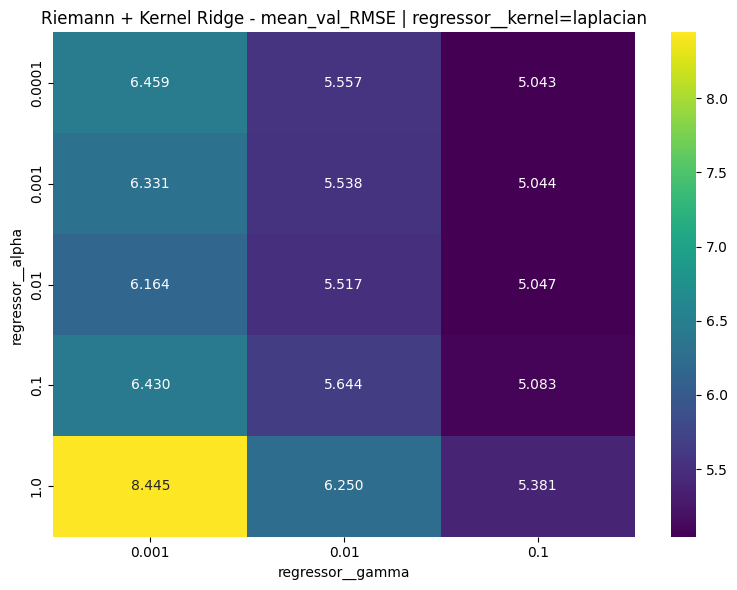

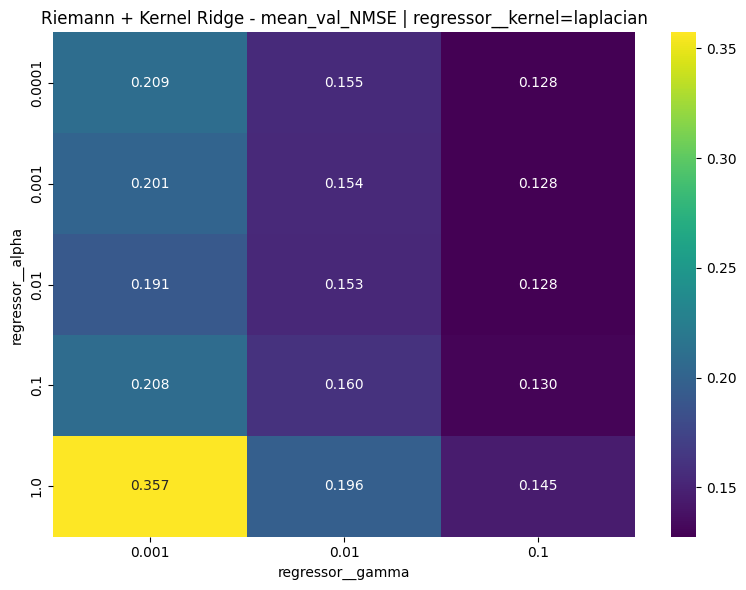

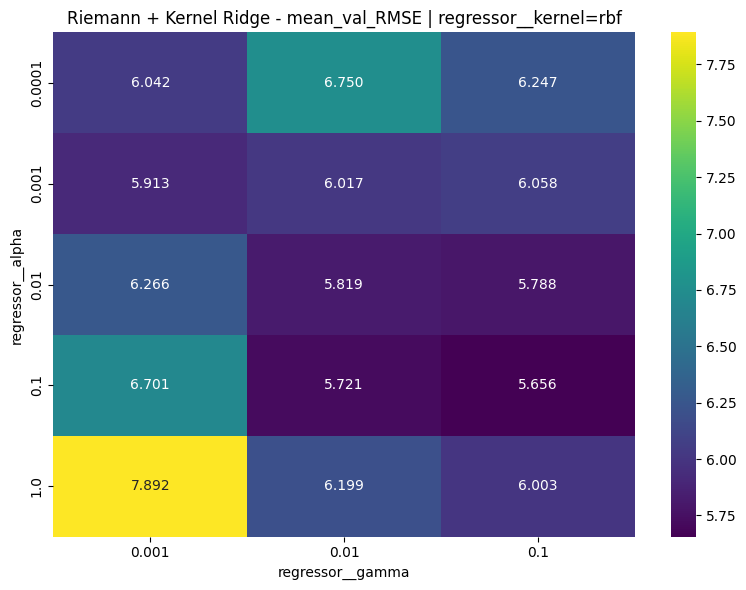

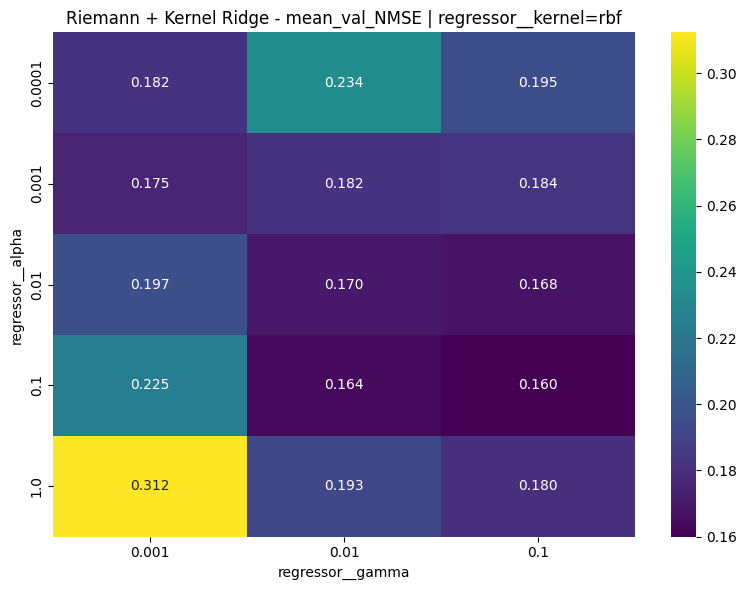

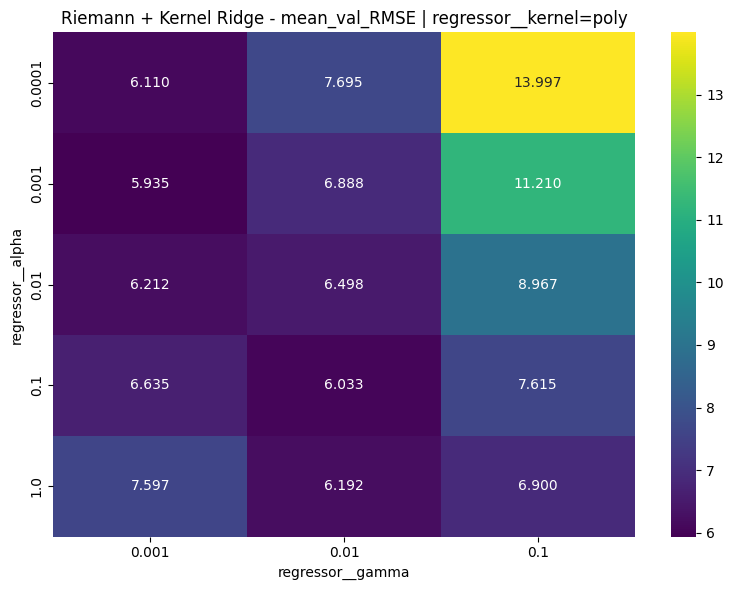

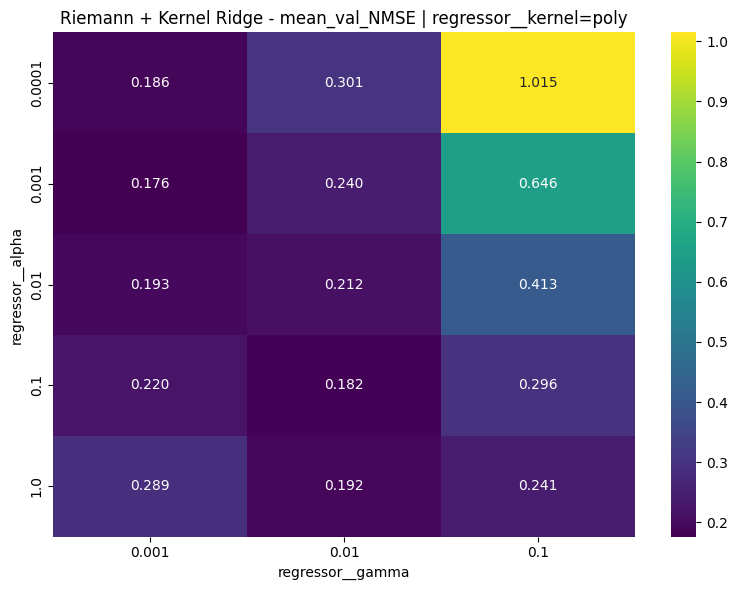

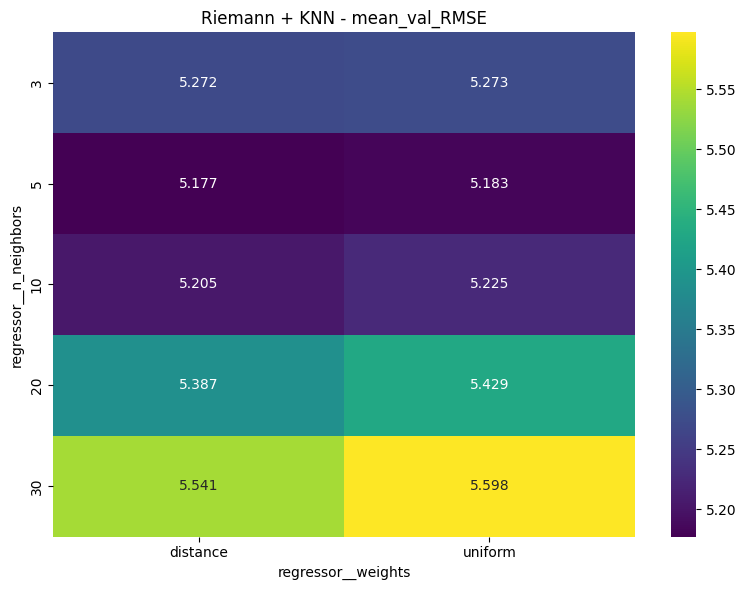

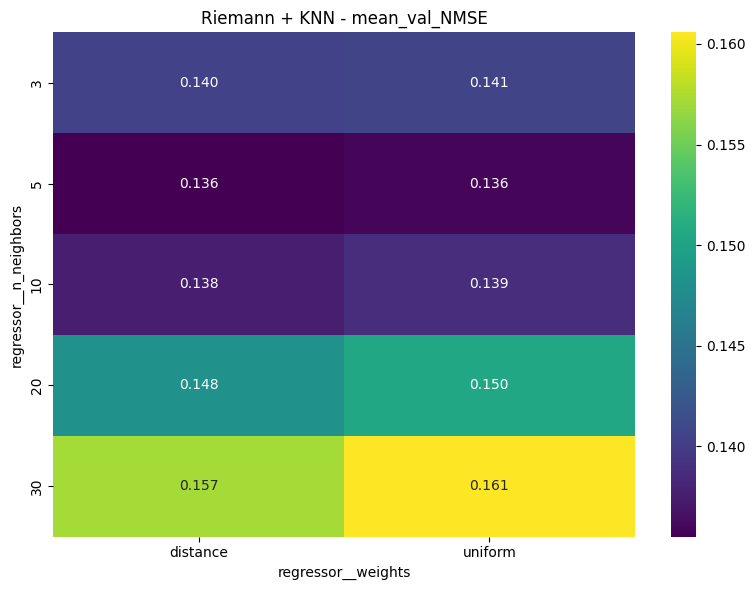

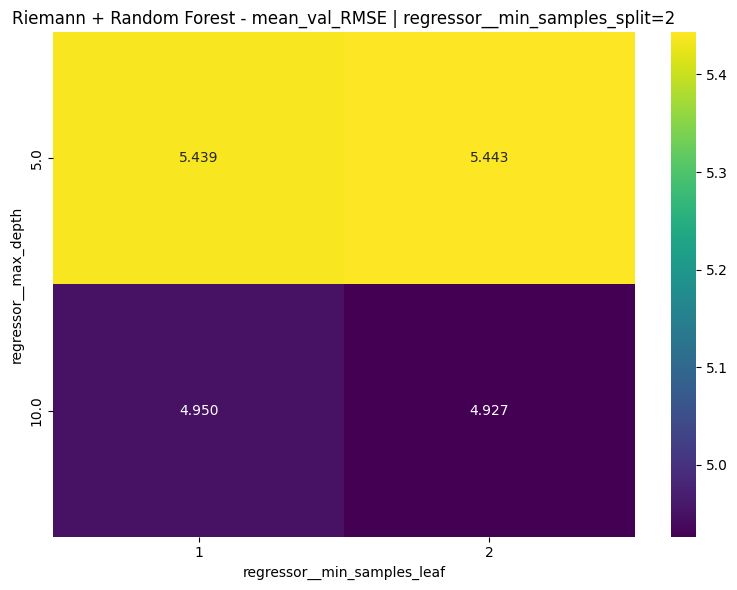

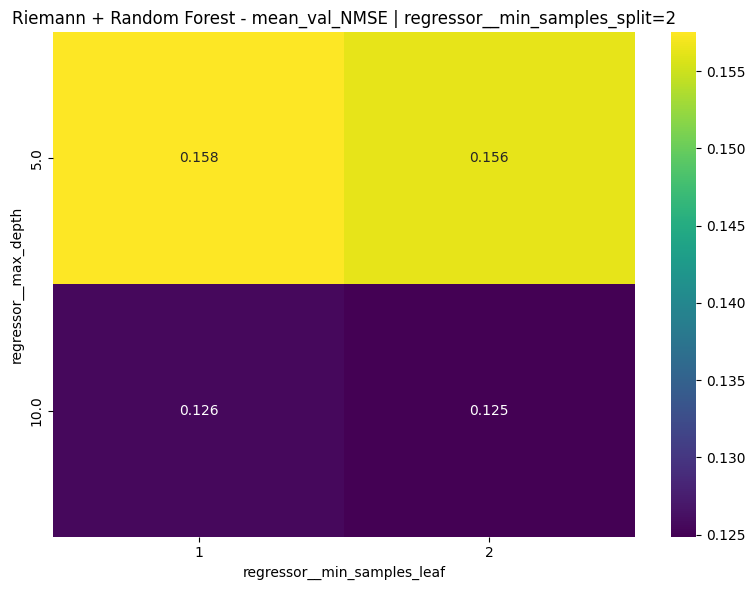

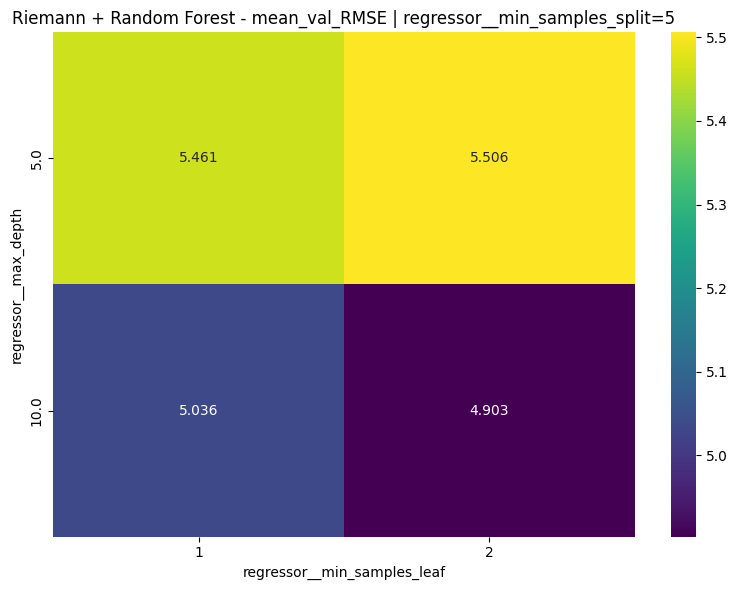

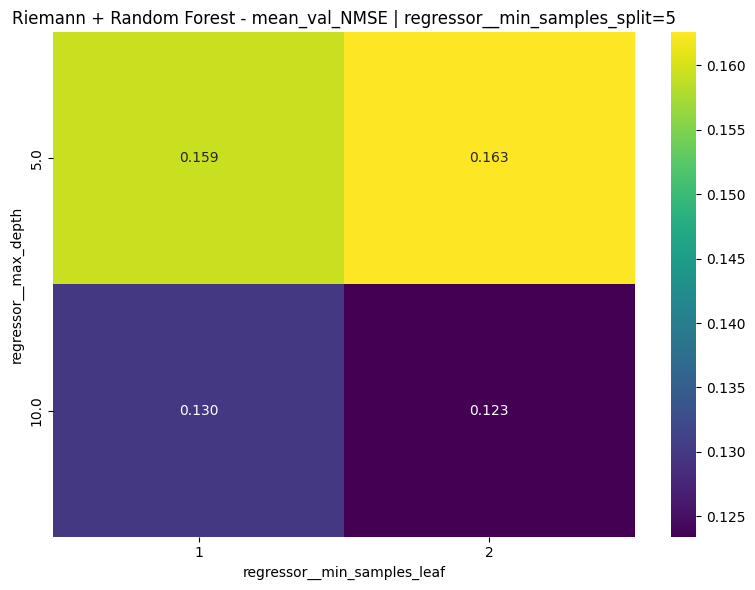

In [28]:
def plot_grid_results(model_name, results):
    """
    Plots RMSE and NMSE heatmaps or line plots for a given model's grid search results.

    Args:
        model_name (str): name of the model
        results (list of dict): results from parameter tuning
    """
    df = pd.DataFrame(results)
    param_cols = [col for col in df['params'][0].keys()]
    for col in param_cols:
        df[f'param_{col}'] = df['params'].apply(lambda d: d[col])

    if len(param_cols) == 1:
        p = f'param_{param_cols[0]}'
        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            plt.figure(figsize=(8, 4))
            plt.plot(df[p], df[metric], marker='o')
            plt.xlabel(param_cols[0])
            plt.ylabel(metric)
            plt.title(f'{model_name} - {metric}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    elif len(param_cols) == 2:
        p1, p2 = f'param_{param_cols[0]}', f'param_{param_cols[1]}'
        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            pivot = df.pivot_table(index=p1, columns=p2, values=metric, aggfunc='mean')
            plt.figure(figsize=(8, 6))
            sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
            plt.title(f'{model_name} - {metric}')
            plt.xlabel(param_cols[1])
            plt.ylabel(param_cols[0])
            plt.tight_layout()
            plt.show()

    else:
        # For >2 hyperparameters, plot line plots for each value of the third+ param
        fixed_param = param_cols[2]
        values = df[f'param_{fixed_param}'].unique()
        for val in values:
            df_subset = df[df[f'param_{fixed_param}'] == val]
            p1, p2 = f'param_{param_cols[0]}', f'param_{param_cols[1]}'
            for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
                pivot = df_subset.pivot_table(index=p1, columns=p2, values=metric, aggfunc='mean')
                plt.figure(figsize=(8, 6))
                sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
                plt.title(f'{model_name} - {metric} | {fixed_param}={val}')
                plt.xlabel(param_cols[1])
                plt.ylabel(param_cols[0])
                plt.tight_layout()
                plt.show()


for model_name, results in all_results.items():
    plot_grid_results(model_name, results)

In [30]:
import json

# You must convert any non-serializable values first (e.g. numpy -> lists)
json_ready = {
    k: [{**d, 'params': {**d['params']}} for d in v]
    for k, v in all_results.items()
}

with open("logs/all_results_riemann.json", "w") as f:
    json.dump(json_ready, f, indent=2)

### Ensemble regressors

In [ ]:
from ensemble import VotingRegressor

ensemble_estimator = VotingRegressor(
    estimators = [baseline2, riem2]
)

result = cross_validate_pipeline(ensemble_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)

### Estimator validation

### Visualizing predictions to unseen data

In [ ]:
X_train_val_flat = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train_val_flat = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

model = ensemble_estimator

model.fit(X_train_val_flat, Y_train_val_flat)
Y_train_pred = model.predict(X_train_val_flat)
Y_test_pred = model.predict(X_test)

print(f"train RMSE:\t{RMSE(Y_train_pred, Y_train_val_flat):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train_val_flat):.4f}")
print(f"test RMSE:\t{RMSE(Y_test_pred, Y_test):.4f}\ttest NMSE:\t{NMSE(Y_test_pred, Y_test):.4f}")

In [ ]:
from visualization_tools import scatter_3d_points

bone = 6
Y_true_bone = Y_test[:,3*bone:3*(bone+1)]
Y_pred_bone = Y_test_pred[:,3*bone:3*(bone+1)]

print(f'RMSE for bone {bone}:', RMSE(Y_pred_bone, Y_true_bone))
print(f'NMSE for bone {bone}:', NMSE(Y_pred_bone, Y_true_bone))

ax = scatter_3d_points(Y_true_bone, color = 'b')
scatter_3d_points(Y_pred_bone, color = 'r', ax = ax)
# ax.set_xlim3d(-50, 50)
# ax.set_ylim3d(-50, 50)
# ax.set_zlim3d(-50, 50)
plt.show()